<img src='images/dask_horizontal.svg' width=400>


## DASK ESCALA PYTHON
<img src='images/dask-overview.svg' width=800>

- Dask agrega herramientas para realizar analisis de datos de forma paralelizada para mayor rendimiento y rapidez
- Para paralelizar se forma un cluster compuesto por un scheduler (distribuye tareas) y un(os) worker(ers) (realiza las operaciones)
- Tiene 3 estructuras basicas: array, bags y dataframe los cuales funcionan con NumPy y Pandas
- Se pueden paralelizar operaciones que no estén contenidas en estas tres operaciones básicas, esto se hace con `Delayed` y `Futures`.


## Buenas prácticas
- Paralelizar siempre agrega complejidad, por lo que es recomendable verificar si el uso de Dask es realmente necesario antes de implementarlo, por ejemplo optimizando nuestro código (muchas veces si se necesita con proyectos grandes).
- Evitar particiones muy grandes, los chunks deben ser suficientemente pequeños para caber en la memoria de los `workers`.
- Evitar gráficas muy grandes. Como vimos, los workloads de Dask funcionan con tareas que el `scheduler` crea para las diferentes particiones (cada tarea es una operación), por lo que podemos evitar saturarla si no aumentamos los chunks correctamente, hacemos demasiadas operaciones separadas, etc.
- Utilizar `threads` si se procesan mayormente números, `processes` si se usan listas, diccionarios o texto.
- Cargar los datos con Dask.
- No usar `compute()` repetidamente, esto bloquea la ejecución en el `client` hasta que el proceso termine. **USAR EL HECHO DE QUE ES LAZY**.
- Aprovechar las gráficas (con `visualize()`) para observar si se puede paralelizar el proceso.

## Creacion de un cluster con `client`
- n_workers = numero de nodos 'worker' que realizan operaciones en el cluster
- threads_per_worker = numero de hilos (unidades de ejecucion) dentro de cada nodo
- memory_limit = limite de memoria RAM que puede utilizar cada worker
- dashboard_address = dirección (puerto) donde se va a ejecutar el cliente (local o distribuidamente)

Donde los hilos comparten memoria dentro del mismo worker y cada worker es una unidad de memoria aislada

In [6]:
import pandas as pd
import numpy as np

In [7]:
from dask.distributed import Client

# Creamos el cliente para el cluster
client = Client(n_workers = 2, threads_per_worker=4, memory_limit='1GB', dashboard_address=':8787')
client

/usr/local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41911 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41911/status,
Dashboard: http://127.0.0.1:41911/status,Workers: 2
Total threads: 8,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37769,Workers: 2
Dashboard: http://127.0.0.1:41911/status,Total threads: 8
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:36649,Total threads: 4
Dashboard: http://127.0.0.1:42347/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:35729,


In [3]:
import dask
dask.config.set(scheduler='threads')
#dask.config.get(scheduler= 'processes')

## Arreglos de Dask
<img src='images/dask-array.svg' width=400>

Creamos un arreglo aleatorio de dimensiones grandes para poder observar como se distribuye un arreglo de Dask.

In [4]:
import dask.array as da

In [5]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Lo que hace este comando es crear un arreglo de Dask de 10000x10000 (que es el primer parámetro) y los representa como arreglos Numpy de 1000x1000. En este caso hay 100 arreglos de Numpy del mismo tamaño, *cada cuadrado naranja es un arreglo de Numpy*.

#### Ejemplos de operaciones sobre arreglos de Dask

In [6]:
y = x + x.T
z = y[::2, 5000:]
z

dask.array<getitem, shape=(5000, 5000), dtype=float64, chunksize=(500, 1000), chunktype=numpy.ndarray>

In [7]:
z = z.mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

Notar que estamos utilizando la misma sintaxis que en Numpy. Estamos sumando la matriz x y su transpuesta y después elegimos las filas de dos en dos, a partir de la columna 5000 y calculamos su media (columnar). Seguimos trabajando con Dask arrays.

In [56]:
z.dask

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x13861fc20>
 0. random_sample-e84301e9893f2ae9b3e8cb8b211e1738
 1. transpose-9d8835105632969a2a8edc164380d6e3
 2. add-4788405acbe3dbe60cc6026c5b1e1bc6
 3. getitem-a3afdcb3c4581b4b69d880bfd2ef4a13
 4. mean_chunk-1225a9b1d4deccf58ee51e11df1e8e0d
 5. mean_combine-partial-e188d1e88307e6dc512c64428f3a6583
 6. mean_agg-aggregate-a0b53bd6c04165f6f13e4686b9a604ae

In [60]:
z.visualize()

In [8]:
z.compute()

array([1.00070367, 0.99951548, 1.00254069, ..., 0.99995627, 0.9928306 ,
       1.00793923])

Se utiliza el comando de `.compute()` cuando queremos realizar las operaciones que se han estado guardando en modo *lazy*. **Lo que compute nos regresa es un arreglo de Numpy**.

## Persist

In [9]:
y = y.persist()

In [10]:
%time y[0, 0].compute()

CPU times: user 96.7 ms, sys: 19.5 ms, total: 116 ms
Wall time: 41.2 ms


np.float64(1.1430683031700546)

In [11]:
%time y.sum().compute()

CPU times: user 729 ms, sys: 171 ms, total: 900 ms
Wall time: 416 ms


np.float64(100001529.63821928)

Por defecto, Dask evalúa las operaciones de manera perezosa. Esto significa que, cuando defines una serie de operaciones sobre un DataFrame o una colección de datos, Dask no ejecuta inmediatamente esas operaciones. En su lugar, construye un grafo de tareas que se ejecutará solo cuando realmente necesites los resultados (por ejemplo, al usar `.compute()`). Si realizas múltiples cálculos en los mismos datos, Dask recalculará desde cero cada vez, lo que puede ser ineficiente.

Cuando tienes suficiente RAM disponible (tu conjunto de datos cabe en RAM), puedes persistir un conjunto de datos en memoria tras realizar algunos cálculos iniciales. Esto significa que los datos intermedios procesados se almacenan directamente en la memoria RAM, evitando el recálculo desde el origen en futuras operaciones.

## Dataframes en Dask
<img src='images/dask-dataframe.svg' width=400>

Los dataframes de dask coordinan muchos dataframes de Pandas , que están particionados en un índice. 

In [13]:
import dask

In [14]:
df= dask.datasets.timeseries()
df

/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/.venv/lib/python3.12/site-packages/dask_expr/_collection.py:6002: UserWarning: dask_expr does not support the DataFrameIOFunction protocol for column projection. To enable column projection, please ensure that the signature of `func` includes a `columns=` keyword argument instead.
  warnings.warn(


,name,id,x,y
npartitions=30,,,,
2000-01-01,string,int64,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [15]:
df.dtypes

name    string[pyarrow]
id                int64
x               float64
y               float64
dtype: object

Al igual que sus arreglos de Numpy, son *lazy*, por lo que no muestra los datos que se tienen cuando se quiere "imprimir" el conjunto de datos. No obstante, podemos acceder a los nombres de las columnas y los tipos de datos de las mismas. Podemos usar, en casi todos los casos, la sintáxis que usaríamos en pandas.

#### Ejemplos de operaciones sobre dataframes de Dask

In [16]:
df2 = df[df.y > 0]
df3 = df2.groupby("name").x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 8 expressions
Expr=(((Filter(frame=ArrowStringConversion(frame=FromMap(400c74e)), predicate=ArrowStringConversion(frame=FromMap(400c74e))['y'] > 0))[['name', 'x']]).std(ddof=1, numeric_only=False, split_out=None, observed=False))['x']

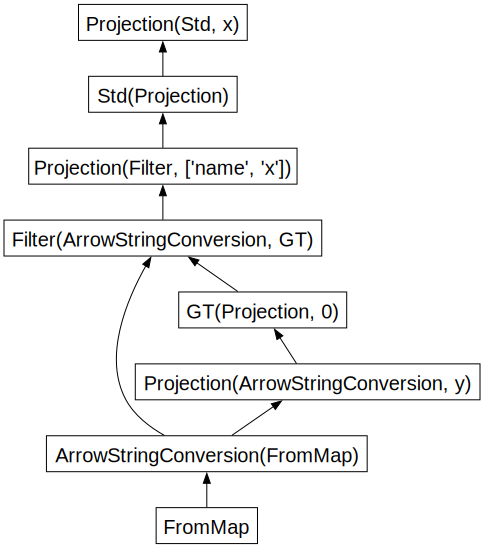

In [62]:
df3.visualize()

In [17]:
computed_df = df3.compute()
type(computed_df)

2024-11-15 11:55:16,417 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 977f4e6932d5fa8a0ec73cab3284f0a5 initialized by task ('shuffle-transfer-977f4e6932d5fa8a0ec73cab3284f0a5', 9) executed on worker tcp://127.0.0.1:53877
2024-11-15 11:55:17,162 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 977f4e6932d5fa8a0ec73cab3284f0a5 deactivated due to stimulus 'task-finished-1731693317.160972'
2024-11-15 11:55:17,309 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 887dd4f84d417e77f86a140e92b887de initialized by task ('shuffle-transfer-887dd4f84d417e77f86a140e92b887de', 9) executed on worker tcp://127.0.0.1:53877
2024-11-15 11:55:17,835 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 887dd4f84d417e77f86a140e92b887de deactivated due to stimulus 'task-finished-1731693317.831664'
2024-11-15 11:55:18,068 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 887dd4f84d417e77f86a140e92b887de initialized by task ('shuffle-transfer-887dd4f84d417e77

pandas.core.series.Series

In [18]:
computed_df

name
Bob         0.578063
Dan         0.577048
Edith       0.577216
George      0.576183
Hannah      0.576634
Ingrid      0.577823
Laura       0.575084
Michael     0.578061
Quinn       0.578131
Ray         0.577234
Sarah       0.579438
Wendy       0.573845
Yvonne      0.577166
Zelda       0.578587
Alice       0.578826
Charlie     0.576348
Frank       0.577668
Jerry       0.577755
Kevin       0.576681
Norbert     0.579375
Oliver      0.575430
Patricia    0.577303
Tim         0.575709
Ursula      0.578559
Victor      0.577404
Xavier      0.575177
Name: x, dtype: float64

In [19]:
df4 = df.groupby("name").aggregate({"x": "sum", "y": "max"})
df4.compute()

,x,y
name,,
Patricia,-142.457007,0.999997
Alice,108.393577,0.999995
Sarah,166.659129,0.999954
Ingrid,24.171990,0.999977
Kevin,7.463306,0.999998
Victor,-220.991238,0.999990
Laura,198.592510,0.999958
Charlie,51.779649,0.999973
Bob,-144.744124,0.999996


In [20]:
df4 = df4.repartition(npartitions=1)
joined = df.merge(
    df4, left_on="name", right_index=True, suffixes=("_original", "_aggregated")
)
joined.head()

,name,id,x_original,y_original,x_aggregated,y_aggregated
timestamp,,,,,,
2000-01-01 00:00:00,Hannah,983,0.694523,-0.987323,-282.428227,0.999999
2000-01-01 00:00:01,Patricia,1030,-0.713981,0.319531,-142.457007,0.999997
2000-01-01 00:00:02,Alice,994,0.618946,0.285541,108.393577,0.999995
2000-01-01 00:00:03,Edith,1034,-0.719690,-0.778922,290.133276,0.999976
2000-01-01 00:00:04,Ursula,996,-0.884174,0.276051,-284.021363,0.999987


In [21]:
df5 = df.set_index("name")
df5

,id,x,y
npartitions=26,,,
Alice,int64,float64,float64
Bob,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


In [22]:
df5.loc["Alice"].compute()

,id,x,y
name,,,
Alice,994,0.618946,0.285541
Alice,941,0.842495,0.175682
Alice,1038,0.558023,0.427142
Alice,1003,0.408852,-0.944784
Alice,1012,0.886356,0.929066
...,...,...,...
Alice,1023,-0.758749,-0.284084
Alice,1010,-0.100867,-0.080473
Alice,997,-0.388612,0.673540


## Dask Bags
Se utilizan para realizar operaciones como `map`, `filter`, `groupby` y agregaciones en colecciones de objetos de Python. Se suelen utilizar para hacer operaciones simples de preprocesado en JSONs.

#### Creamos y guardamos los datos en una bolsa

In [29]:
import dask
import json
import os

os.makedirs('data/jsons', exist_ok=True)              # Create data/jsons directory

b = dask.datasets.make_people()                 # Make records of people
b.map(json.dumps).to_textfiles('data/jsons/*.json')   # Encode as JSON, write to disk

['/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/0.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/1.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/2.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/3.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/4.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/5.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/6.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/7.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/8.json',
 '/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/data/jsons/9.json']

In [31]:
import dask.bag as db
import json

b = db.read_text('data/jsons/*.json').map(json.loads)
b

dask.bag<loads, npartitions=10>

In [32]:
b.take(2)

({'age': 71,
  'name': ['Samuel', 'Hall'],
  'occupation': 'Public Relations Of?cer',
  'telephone': '+12398868058',
  'address': {'address': '1144 Godeus Terrace', 'city': 'Kennesaw'},
  'credit-card': {'number': '3485 605046 00812', 'expiration-date': '11/16'}},
 {'age': 79,
  'name': ['Joseph', 'Bradley'],
  'occupation': 'Shelter Warden',
  'telephone': '+1-302-719-2005',
  'address': {'address': '770 Amity Pike', 'city': 'Yuma'},
  'credit-card': {'number': '3719 634015 63408', 'expiration-date': '01/16'}})

#### Funciones

In [33]:
b.filter(lambda record: record['age'] > 30).take(2)

({'age': 71,
  'name': ['Samuel', 'Hall'],
  'occupation': 'Public Relations Of?cer',
  'telephone': '+12398868058',
  'address': {'address': '1144 Godeus Terrace', 'city': 'Kennesaw'},
  'credit-card': {'number': '3485 605046 00812', 'expiration-date': '11/16'}},
 {'age': 79,
  'name': ['Joseph', 'Bradley'],
  'occupation': 'Shelter Warden',
  'telephone': '+1-302-719-2005',
  'address': {'address': '770 Amity Pike', 'city': 'Yuma'},
  'credit-card': {'number': '3719 634015 63408', 'expiration-date': '01/16'}})

In [34]:
b.map(lambda record: record['occupation']).take(2)

('Public Relations Of?cer', 'Shelter Warden')

In [37]:
b.count().compute()

10000

También, podemos aprovechar que las bolsas de Dask son *lazy*, por lo que podemos hacer operaciones agregadas que sean más rápidas.

In [38]:
result = (b.filter(lambda record: record['age'] > 30)
           .map(lambda record: record['occupation'])
           .frequencies(sort=True)
           .topk(10, key=1))
result

dask.bag<topk-aggregate, npartitions=1>

In [39]:
result.compute()

[('Premises', 16),
 ('Log Merchant', 15),
 ('Technical Manager', 15),
 ('Ambulance Driver', 15),
 ('Publishing Manager', 14),
 ('Marketing Assistant', 14),
 ('Paediatrician', 14),
 ('Optical Assistant', 14),
 ('Market Researcher', 14),
 ('Travel Representative', 14)]

## Delayed y Futures
Si queremos paralelizar código genérico de python en lugar de solamente arreglos, dataframes o bolsas, podemos utilizar las herramientas de `Delayed` y `Futures` que ofrece Dask. Ambas herramientas paralelizan los procesos, `Delayed` hace las operaciones lazy, `Futures` las manda a ejecutar de forma remota inmediatamente. Es importante mencionar que la función de `Futures` solo puede usarse con un cluster distribuido.

In [2]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

In [3]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Hacemos que las funciones que definimos sean delayed con Dask.

In [4]:
x = inc(1)
y = dec(2)
z = add(x, y)
z

Delayed('add-d469f616-5d93-4c9b-a995-e6889a0a779a')

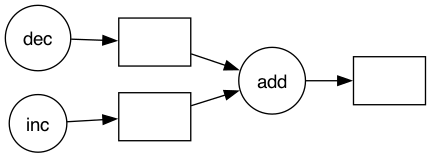

In [5]:
z.visualize(rankdir='LR')

In [15]:
z.compute()

3

Para utilizar delayed podemos, utilizar el `@dask.delayed` o llamar a `dask.delayed()`. Lo que ocurre es que provoca que la función sea *lazy*, lo que permite que se paralelice código que ya tengamos una vez observada la gráfica generada de ejecución podemos ver que se paralelizará `dec` e `inc`. El proceso es paralelizado una vez que indicamos `z.compute()`.

In [18]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def double(x):
    time.sleep(random.random())
    return 2 * x

def add(x, y):
    time.sleep(random.random())
    return x + y

In [ ]:
future = client.submit(inc, 1)  
future

<Future: pending, key: inc-a5956d77d53b62811264b745408b0dac>

In [20]:
future

<Future: finished, type: int, key: inc-a5956d77d53b62811264b745408b0dac>

In [21]:
future.result()

2

Lo que estamos haciendo es "entregando" la función para que corra de manera remota con Dask. Esto inmediatamente regresa un `Future` que apunta al cálculo y eventualmente guardará el resultado. Podemos ver comom el flujo es que el `Future` está pendiente, se termina (guarda el cálculo) y podemos acceder a él.

In [22]:
x = client.submit(inc, 1)
y = client.submit(double, 2)
z = client.submit(add, x, y)
z

<Future: pending, key: add-61bdf5157f4c3682fda7aa87e2d41bf0>

In [23]:
z.result()

6

De momento parece de poca utilidad, pero en realidad con esto se puede:
- Mandar miles de operaciones por segundo de manera remota 
- Las tareas pueden depender una de la otra consumiento `futures` como entradas, por lo que mandamos todo remoto y se comienza a ejecutar cuando lo mandemos

El hecho de que utilicemos `sleep()` en nuestras funciones es para, en la interfaz de dask, poder observar como, al ser inmediato y paralelo, si realizamos 10 operaciones, en vez de "dormir" 10 segundos, "dormirá" el número de threads o processes que tengamos (porque es paralelo).